### **Using OpenAI Whisper**
#### Transcribing TikTok videos

##### *Author: @Jyontika Kapoor*

In [1]:
from openai import OpenAI
import requests
from docx import Document
import os
import whisper
import pandas as pd
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import json 
import matplotlib.pyplot as plt
import librosa
cwd = os.getcwd()

/var/folders/94/hzlwrw5d571cgm5snsf618b00000gn/T/ipykernel_52016/3692569134.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Pre-Processing CSVs

In [74]:
### Merging Audrey and Tayae's videos

poster = pd.read_csv("/Users/jyontika/Documents/GitHub/CS315-Project-2/analysis/news_accs/news_by_poster.csv")

hashtag = pd.read_csv("/Users/jyontika/Documents/GitHub/CS315-Project-2/analysis/hashtag_initial/news_by_hashtag.csv")

nyt = pd.read_csv("/Users/jyontika/Documents/GitHub/CS315-Project-2/analysis/top_cosine_similarities.csv")


# Merge the DataFrames and keep only the 'video_id' column
merged_df = pd.concat([poster['video_id'], hashtag['video_id'], nyt['video_id']], ignore_index=True)

# remove duplicates
merged_df = merged_df.drop_duplicates()

# shuffle the indices randomly
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(merged_df)



0      7288055765938670894
1      7302611720214957358
2      7301777464840277294
3      7289551496524467502
4      7289467129089461550
              ...         
470    7305077915966852358
471    7305541674766241054
472    7290970440023969057
473    7295843462497226015
474    7303352147972721962
Name: video_id, Length: 475, dtype: int64


In [16]:
##Change the video_ids to URLs

urls = ["https://www.tiktokv.com/share/video/" + str(video_id) + "/" for video_id in merged_df]

# convert  list of URLs to a DataFrame
urls_df = pd.DataFrame(urls, columns=['Link'])

print(urls_df)

                                                  Link
0    https://www.tiktokv.com/share/video/7288055765...
1    https://www.tiktokv.com/share/video/7302611720...
2    https://www.tiktokv.com/share/video/7301777464...
3    https://www.tiktokv.com/share/video/7289551496...
4    https://www.tiktokv.com/share/video/7289467129...
..                                                 ...
470  https://www.tiktokv.com/share/video/7305077915...
471  https://www.tiktokv.com/share/video/7305541674...
472  https://www.tiktokv.com/share/video/7290970440...
473  https://www.tiktokv.com/share/video/7295843462...
474  https://www.tiktokv.com/share/video/7303352147...

[475 rows x 1 columns]


In [17]:
##Randomly choose 300 and turn to dataframe
sampled_urls_df = urls_df.sample(n=300, random_state=42)


json_data = sampled_urls_df.to_dict(orient='records')

# Export the JSON data to a file
with open("sampled_tiktok_urls.json", "w") as json_file:
    json.dump(json_data, json_file, indent=4)




In [4]:
downloaded_vids = pd.read_csv("videos-downloaded.csv")
downloaded_vids.shape

(392, 20)

In [29]:
video_ids = downloaded_vids['video_id']
video_ids

0      7290493831408045330
1      7295925652992363822
2      7175869072263990533
3      7304461225448967467
4      7298442585964662046
              ...         
291    7300191041280412933
292    7293283723934453038
293    7297044924862647595
294    7287549870171245854
295    7291460094032645418
Name: video_id, Length: 296, dtype: int64

### Transcription

In [18]:
#client = OpenAI(api_key=XYZ)

!pip install git+https://github.com/openai/whisper.git

In [33]:

# Load the WhisperProcessor and WhisperForConditionalGeneration models
processor = WhisperProcessor.from_pretrained("openai/whisper-large")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large")

# set forced_decoder_ids to None for unforced context tokens
model.config.forced_decoder_ids = None  



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [37]:
output_path = "txt-transcripts/"

# define sampling rate
sampling_rate = 16000  

for video_id in video_ids:
    audio_path = f"videos/share_video_{video_id}_.mp4"


    if os.path.exists(audio_path):

        # load the audio file using librosa
        audio, sr = librosa.load(audio_path, sr=sampling_rate)

        # process the audio using WhisperProcessor
        input_features = processor(audio, sampling_rate=sampling_rate, return_tensors="pt").input_features

        # generate token ids for transcription
        predicted_ids = model.generate(input_features)

        # decode token ids to text
        transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

        # write transcription to a text file named after the video ID
        with open(os.path.join(output_path, f"{video_id}.txt"), "w", encoding="utf-8") as txt:
            txt.write(transcription)

    else:
        # If audio file not found
        print(f"Audio for video ID {video_id} not found.")


/var/folders/94/hzlwrw5d571cgm5snsf618b00000gn/T/ipykernel_32177/824772569.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_path, sr=sampling_rate)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
/var/folders/94/hzlwrw5d571cgm5snsf618b00000gn/T/ipykernel_32177/824772569.py:15: UserWarning: PySoundFile failed. Trying audioread

Audio for video ID 7298062755058240801 not found.
Audio for video ID 7289462001636576545 not found.
Audio for video ID 7305077915966852358 not found.
Audio for video ID 7287429952792841504 not found.
Audio for video ID 7289223591458131231 not found.
Audio for video ID 7300367621764091182 not found.
Audio for video ID 7292143951392492846 not found.
Audio for video ID 7304509572847521070 not found.
Audio for video ID 7289551496524467502 not found.
Audio for video ID 7267165450637790482 not found.
Audio for video ID 7290970440023969057 not found.
Audio for video ID 7294334382150651168 not found.
Audio for video ID 7291766284549786926 not found.
Audio for video ID 7288487297316572421 not found.
Audio for video ID 7293537949860367658 not found.
Audio for video ID 7290224386152484101 not found.
Audio for video ID 7287680374539423018 not found.
Audio for video ID 7288531043681062149 not found.
Audio for video ID 7290565797792222510 not found.
Audio for video ID 7290322507800890670 not found.


### Update downloaded CSV

In [39]:
# Step 1: Read videos_not_downloaded.csv and extract IDs
not_downloaded_df = pd.read_csv('videos-not-downloaded.csv')

not_downloaded_ID = not_downloaded_df['video_url'].str.extract(r'(\d+)/$')[0].tolist()

not_downloaded_ID = [int(x) for x in not_downloaded_ID]


In [40]:
#Remove rows with matching video_id
new_downloaded_vids = downloaded_vids[~downloaded_vids['video_id'].isin(not_downloaded_ID)]


# Step 4: Save modified videos_downloaded.csv
new_downloaded_vids.to_csv('videos_downloaded.csv', index=False)

In [41]:
new_downloaded_vids.shape

(365, 20)

### Analyze Transcription Lengths

In [68]:
folder_path = os.path.join(cwd, 'txt-transcripts')

# List to store lengths of all files
file_lengths = []

# Iterate through all .txt files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as file:
            # Read the file and calculate its length (e.g., number of characters)
            file_length = len(file.read())
            file_lengths.append(file_length)




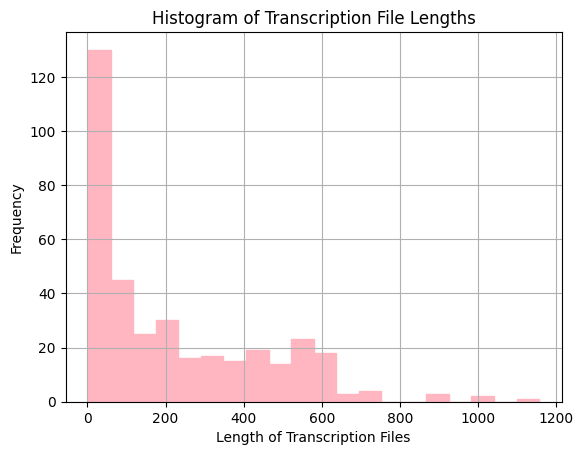

In [72]:
# Plot a histogram of file lengths
plt.hist(file_lengths, bins=20, color='lightpink', edgecolor='lightpink')
plt.xlabel('Length of Transcription Files')
plt.ylabel('Frequency')
plt.title('Histogram of Transcription File Lengths')
plt.grid(True)
plt.show()

In [85]:
poster_ID = poster["video_id"].tolist()
hashtag_ID = hashtag["video_id"].tolist()
nyt_ID = nyt["video_id"].tolist()
downloaded_ID = new_downloaded_vids["video_id"].tolist()

In [98]:
poster_downloaded = []
hashtag_downloaded = []
nyt_downloaded = []

counter = 0

for video_id in downloaded_ID:

    if video_id in poster_ID:
        poster_downloaded.append(video_id)

    if video_id in hashtag_ID:
        hashtag_downloaded.append(video_id)

    if video_id in nyt_ID:
        nyt_downloaded.append(video_id)

    if video_id in merged_df.tolist():
        counter += 1

In [101]:
counter

179

In [91]:
len(downloaded_ID)

365

In [92]:
len(nyt_downloaded) + len(hashtag_downloaded) + len(poster_downloaded)

193